# Numerical Wasserstein Gradient Flow via Sinkhorn's Algorithm
Throughout the notebook, let us adapt the following setting. For $n \in \mathbb{N}$, define $\Omega \subseteq \mathbb{R}^n$ be a compact subset of $n$ dimensional Euclidean space, and $\mathcal{P}(\Omega)$ be a space of Borel probability measures on $\Omega$. The 2-Wasserstein space is defined as a metric space of probability measures endowed with what so called a 2-Wasserstein metric $W_2: \mathcal{P}(\Omega) \times \mathcal{P}(\Omega) \to [0,\infty]$, defined as, $$W_2(\mu,\nu) = \left( \inf_{\gamma \in \Pi(\mu,\nu)} \int_{\Omega^2} \vert x-y\vert^2 d\gamma(x,y) \right)^{1/2}$$ where $\Pi(\mu,\nu) \coloneqq \{\gamma \in \mathcal{P}(\Omega^2) : \pi_{1}\sharp\gamma = \mu, \pi_{2}\sharp\gamma = \nu\}$.

In [1]:
from src.jko_lab import * # solvers
from src.utils import * # graphing utilities
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
from __future__ import annotations
Array = jnp.ndarray

## Entropy Flow
Shannon entropy $\mathcal{F}[\rho]: \mathcal{P}(\Omega) \to \mathbb{R}$ is a functional defined by
$$
F[\rho] = \int_{\Omega} \rho (\log \rho - 1) \: d\rho.
$$
Then, by taking $\mathcal{F}[\rho]$ as an external potential for the following entropic JKO scheme
$$
\rho^{k+1} = \underset{\rho \in \mathcal{P}(\Omega)}{\arg\min} \left\{ \int_{\Omega} \rho (\log \rho - 1) d\rho + \frac{1}{2\eta} W_{2,\epsilon}^2(\rho,\rho^k) \right\},
$$
as JKO step size $\eta \to 0$, corresponding Wasserstein gradient flow $(\rho^{k})_{k\in \mathbb{N}}$ approximates the heat equation
$$
\partial_t \rho_t = \nabla \cdot (\nabla \rho)
$$
with $\rho_0 = \rho^0 \in \mathcal{P}(\Omega)$.

### Setup
Upon spatial discretization in $n$ grid points, we get the explicit formulation of discrete Shannon entropy as
$$\mathcal{F}[\rho] = \sum_{i=1}^{n} \rho_i (\log \rho_i - 1)$$
with $\rho \in \Sigma_n$. Since this functional is separable, its first variation, i.e. derivative, is given by
$$\frac{\delta F}{\delta \rho} = \sum_{i=1}^{n} \log \rho_i.$$

In [2]:
def F_shannon_entropy(rho: jax.Array) -> jax.Array:
    """
    Shannon entropy of a probability measure rho
    """
    rho_safe = jnp.clip(rho, 1e-12, None) # prevent log(0)
    return jnp.sum(rho_safe * jnp.log(rho_safe) - rho_safe)

In this example, let us flow for a total $T = \eta \times n = 50$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively. Let us start from a bimodal initial distribution $\rho^0 = 0.5\mathcal{N}(0.25,0.03)+0.5\mathcal{N}(0.75,0.04)$.

In [3]:
n = 100             # spatial discretization                
T_TARGET = 50       # total time of the flow

x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# initial measure
rho0 = 0.5 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.5 * jax.scipy.stats.norm.pdf(x,0.75,0.04)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

Due to the nature of heat equation, as $k \to \infty$, sequence of probability measures $\rho^k$ generated from the scheme should converge to an uniform distribution $b \in \mathcal{P}(\Omega)$.

In [4]:
# target measure is uniform
b = jnp.ones_like(x)/n
b = b / b.sum()

The numerical stability of the scheme is sharply determined by the choice of $\eta$ and $\epsilon$. After running a hyperparameter optimization on $(\eta, \epsilon)$, it found that $\eta = 10^{-2}$ and $\epsilon = 15$ are optimal.

In [5]:
eta = 1e-3                              # JKO step size
epsilon = 1e-1                          # regularization parameter of inner Sinkhorn iterations
sinkhorn_max_iters = 2000               # maximum number of inner Sinkhorn iterations
jko_tol = 1e-8                          # tolerance for inner Sinkhorn approximation
jko_lr = 0.01                           # learning rate of outer SGD iterations
jko_inner_steps = 10                    # number of outer SGD iterations
num_jko_steps = int(T_TARGET / eta)     # automatically determined by eta

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \underset{\rho \in \Sigma_n}{\arg\min} \left\{ \sum_{i=1}^{n} \rho_i(\log\rho_i-1) + \frac{1}{2\eta}
\sup_{f,g \in \mathbb{R}^n} \left[ \sum_{i=1}^{n} f_i \rho_i + \sum_{i=1}^{n} g_i \rho^k_i - \epsilon \sum_{i,j} e^{f_i + g_i - c_{ij}} \right]\right\}
$$
with parameters that are chosen from above.

In [ ]:
jko_flow = SinkhornJKO(
    C=C,                                # Euclidean distance matrix
    rho0=rho0,                          # starting marginal
    eta=eta,                            # JKO step size
    epsilon=epsilon,                    # regularization parameter
    F_func=F_shannon_entropy,           # external potential
    sinkhorn_iters=sinkhorn_max_iters,  # set to 2,000
    inner_steps=jko_inner_steps,        # set to 10
    tol=jko_tol,                        # set to 1e-9
    learning_rate=jko_lr,               # set to 0.01
    optimizer_name='sgd'                # may choose adam, sgd, or etc.
)

rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)

Let us verify the convergence of the algorithm. As the heat equation must flow to maximize the entropy $$E[\rho] = -\int \rho \log \rho d\rho,$$ we should witness an increment in entropy and decrement in distance to uniform target marginal. Measure $\vert\vert \rho^k - b \vert\vert_{2}$ and $E[\rho^k]$ for each $k \geq 1$.

In [7]:
def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))

print("Computing L2 errors of measures...")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing Entropy of measures...")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
k_steps_to_print = [i for i in [0, 10, 50, 100, 500, 1000, 2500, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

Computing L2 errors of measures...
Computing Entropy of measures...

Target Uniform Entropy: 4.605170
[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k=  0: H=3.344489, ||rho-b||=0.177635
 k= 10: H=3.628621, ||rho-b||=0.134788
 k= 50: H=3.822483, ||rho-b||=0.111479
 k=100: H=3.898330, ||rho-b||=0.103193
 k=500: H=4.057695, ||rho-b||=0.086233
 k=1000: H=4.121928, ||rho-b||=0.079570
 k=2500: H=4.190029, ||rho-b||=0.072715
 k=49999: H=4.589510, ||rho-b||=0.017240


The following diagnostic illustrates how warm starting JKO steps with Kantorovich potentials from previous step benefits the convergence speed of the algorithm.

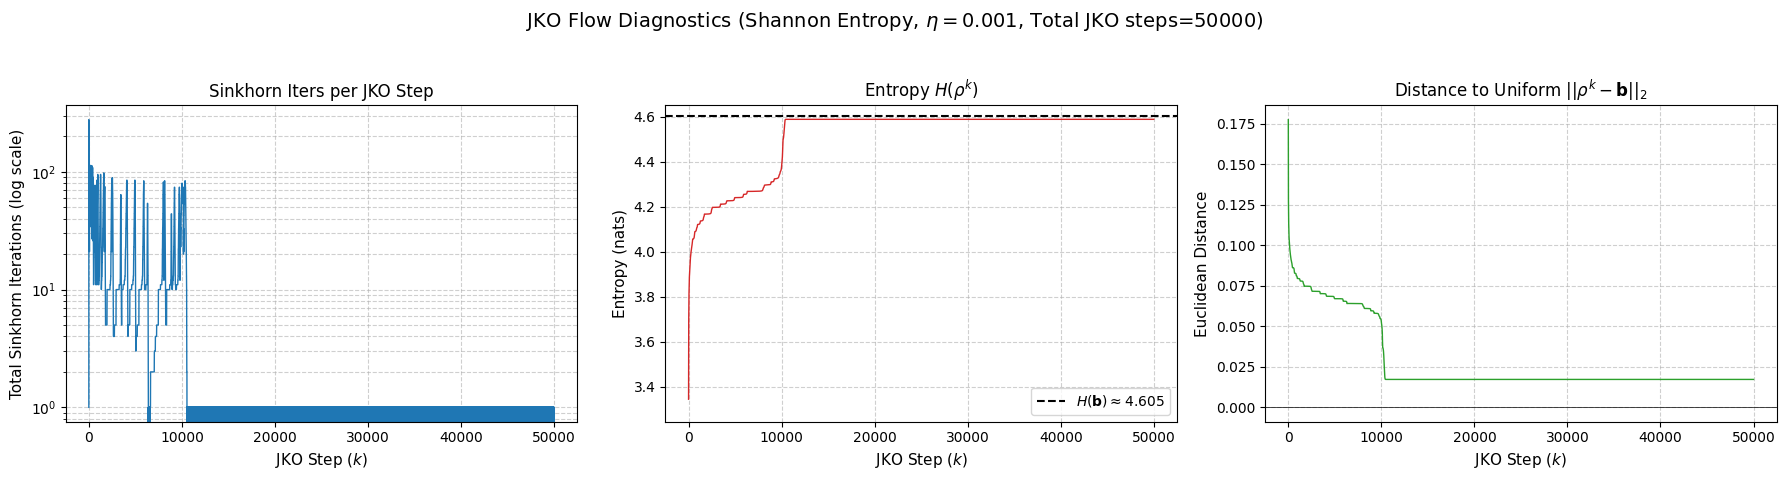

In [8]:
x = np.linspace(0, num_jko_steps, num_jko_steps+1)
sinkhorn_iters_per_jko = np.insert(np.asarray(diag['sinkhorn_iters_per_jko_step'].sum(axis=1)),0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"JKO Flow Diagnostics (Shannon Entropy, $\\eta={eta}$, Total JKO steps={num_jko_steps})", fontsize=14)

# Plot 1: Sinkhorn Iterations
axes[0].plot(x, sinkhorn_iters_per_jko, linestyle='-', color='tab:blue', linewidth=1)
axes[0].set_title('Sinkhorn Iters per JKO Step', fontsize=12)
axes[0].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[0].set_ylabel('Total Sinkhorn Iterations (log scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].grid(True, which="both", linestyle='--', alpha=0.6)
axes[0].tick_params(axis='y', which='minor', labelsize=8)

# Plot 2: Entropy
axes[1].plot(x, Hs, linestyle='-', color='tab:red', linewidth=1)
axes[1].axhline(y=float(uniform_H), color='k', linestyle='--', label=r'$H(\mathbf{b}) \approx 4.605$')
axes[1].set_title('Entropy $H(\\rho^k)$', fontsize=12)
axes[1].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[1].set_ylabel('Entropy (nats)', fontsize=11)
axes[1].set_ylim(bottom=Hs.min() - 0.1)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Distance
axes[2].plot(x, dists, linestyle='-', color='tab:green', linewidth=1)
axes[2].set_title(r'Distance to Uniform $||\rho^k - \mathbf{b}||_2$', fontsize=12)
axes[2].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[2].set_ylabel(r'Euclidean Distance', fontsize=11)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The following cell describes the flow in animated histograms.

In [ ]:
x = jnp.linspace(0.0, 1.0, n)
html = animate_hist_flow(  
    mu_list=rhos, x=np.asarray(x),
    target=b,
    interval=50,
    title="JKO Flow (Shannon Entropy)"
)
html

Animation size has reached 20971655 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


## Porous Media Equation
Let $\mathcal{F}[\rho]$ be a functional defined by
$$\mathcal{F}[\rho]=\frac{1}{m-1}\int_{\Omega}\rho^m d\rho,$$
for $m\geq 1$. Then, by taking $\mathcal{F}[\rho]$ as an external potential for the following entropic JKO scheme
$$
\rho^{k+1} = \underset{\rho\in\mathcal{P}(\Omega)}{\arg\min}\left\{ \frac{1}{m-1}\int_{\Omega}\rho^m d\rho + \frac{W_2^2(\rho,\rho^k)}{2\eta} \right\}
$$
as JKO step size $\eta \to 0$, corresponding Wasserstein gradient flow $(\rho^k)_{k\in\mathbb{N}}$ approximates the porous media equation
$$\partial_t \rho_t = \nabla^2 \mathcal{F}(\rho) = \nabla \cdot (\nabla \mathcal{F}(\rho))$$
with $\rho_0 = \rho^0 \in \mathcal{P}(\Omega)$.

### Setup
Upon spatial discretization in $n$ grid points, we get the explicit formulation of discrete porous media entropy as
$$F[\rho] = \frac{1}{m-1}\sum_{i=1}^{n} \rho_i^m$$
with $m > 1$. As a separable functional on Euclidean space, its first variation, which is equivalent to the derivative in this case, is going to be
$$
\frac{\delta F}{\delta\rho} = \frac{m}{m-1} \sum_{i=1}^{n} \rho_i^{m-1}
$$
via pointwise differentiation.

In [ ]:
def grad_F_porous_media(rho, m=2):
    """
    Gradient of porous media entropy of a probability measure rho with (m > 1)
    """
    return jnp.sum(jnp.power(rho, m-1).clip(1e-100, None)) * m/(m-1)

In this example, let us flow for a total $T = \eta \times n = 50$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively. Let us start from a bimodal initial distribution $\rho^0 = 0.6\mathcal{N}(0.3,0.04) + 0.4\mathcal{N}(0.75,0.05)$.

In [ ]:
n = 300                 # spatial discretization
T_TARGET = 5            # total time of the flow
m = 1.1                 # try 1.5 or 3.0 as well

x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# initial measure
rho0 = 0.6 * jax.scipy.stats.norm.pdf(x, 0.3, 0.04) + 0.4 * jax.scipy.stats.norm.pdf(x, 0.75, 0.05)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

Due to the nature of porous media equation, as $k \to infty$, a sequence of probability measures $\rho^k$ generated from the scheme should converge to an uniform distribution $b \in \mathcal{P}(\Omega)$.

In [ ]:
# target measure is uniform
b = jnp.ones_like(x) / n
b = b / b.sum()

The numerical stability of the scheme is sharply determined by the choice of $\eta$ and $\epsilon$. After running a hyperparameter optimization on $(\eta, \epsilon)$, it found that $\eta = 10^{-2}$ and $\epsilon = 15$ are optimal.

In [ ]:
eta = 1e-3                              # JKO step size
epsilon = 5e-2                          # regularization parameter of inner Sinkhorn iterations
sinkhorn_max_iters = 15000              # maximum number of inner Sinkhorn iterations
jko_tol = 1e-9                          # tolerance for inner Sinkhorn approximation
jko_lr = 0.01                           # learning rate of outer SGD iterations
jko_inner_steps = 10                    # number of outer SGD iterations
num_jko_steps = 200                     # automatically determined by eta

### Convergence and Diagnostics
For each $k > 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \underset{\rho \in \Sigma_n}{\arg\min} \left\{\sum_{i=1}^{n} \rho_i^m + \frac{1}{2\eta}
\sup_{f,g \in \mathbb{R}^n} \left[ \sum_{i=1}^{n} f_i \rho_i + \sum_{i=1}^{n} g_i \rho^k_i - \epsilon \sum_{i,j} e^{f_i + g_i - c_{ij}} \right]\right\}
$$
with parameters that are chosen from above.

In [ ]:
jko_flow = SinkhornJKO(
    C=C,                                # Euclidean distance matrix
    rho0=rho0,                          # starting marginal
    eta=eta,                            # JKO step size
    epsilon=epsilon,                    # regularization parameter
    grad_F_func=grad_F_porous_media,    # external potential
    sinkhorn_iters=sinkhorn_max_iters,  # set to 2,000
    inner_steps=jko_inner_steps,        # set to 10
    tol=jko_tol,                        # set to 1e-9
    learning_rate=jko_lr,               # set to 0.01
    optimizer_name='adam'               # may choose adam, sgd, or etc.
)

rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)

Let us verify the convergence of the algorithm. We should witness decrement in both distance to uniform target marginal $b$ and peak of the distribution $\rho^k$. Measure $\vert\vert \rho^k - b\vert\vert_2$ and $\max[\rho^k]$ for each $k \geq 1$.

In [ ]:
def l2_to_uniform(r):
    return float(jnp.linalg.norm(r - b))

def rmax(r):
    return float(jnp.max(r))

print("[Flow-PorousMedia] toward uniform (expect ||rho-b|| ↓, max(rho) ↓):")
for k in [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]:
    r = rhos[k]
    print(f"  k={k:2d}: ||rho-b||={l2_to_uniform(r):.6f}, max(rho)={rmax(r):.6f}")

The following diagnostic illustrates how warm starting JKO steps with Kantorovich potentials from previous step benefits the convergence speed of the algorithm.

In [ ]:
x = np.linspace(0, num_jko_steps, num_jko_steps+1)
sinkhorn_iters_per_jko = np.insert(np.asarray(diag['sinkhorn_iters_per_jko_step'].sum(axis=1)),0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"JKO Flow Diagnostics (Shannon Entropy, $\\eta={eta}$, Total JKO steps={num_jko_steps})", fontsize=14)

# Plot 1: Sinkhorn Iterations
axes[0].plot(x, sinkhorn_iters_per_jko, linestyle='-', color='tab:blue', linewidth=1)
axes[0].set_title('Sinkhorn Iters per JKO Step', fontsize=12)
axes[0].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[0].set_ylabel('Total Sinkhorn Iterations (log scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].grid(True, which="both", linestyle='--', alpha=0.6)
axes[0].tick_params(axis='y', which='minor', labelsize=8)

# Plot 2: Entropy
axes[1].plot(x, Hs, linestyle='-', color='tab:red', linewidth=1)
axes[1].axhline(y=float(uniform_H), color='k', linestyle='--', label=r'$H(\mathbf{b}) \approx 4.605$')
axes[1].set_title('Entropy $H(\\rho^k)$', fontsize=12)
axes[1].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[1].set_ylabel('Entropy (nats)', fontsize=11)
axes[1].set_ylim(bottom=Hs.min() - 0.1)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Distance
axes[2].plot(x, dists, linestyle='-', color='tab:green', linewidth=1)
axes[2].set_title(r'Distance to Uniform $||\rho^k - \mathbf{b}||_2$', fontsize=12)
axes[2].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[2].set_ylabel(r'Euclidean Distance', fontsize=11)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The following cell describes the flow in animated histograms.

In [ ]:
x = jnp.linspace(0.0, 1.0, n)
html = animate_hist_flow(  
    mu_list=rhos, x=np.asarray(x),
    target=b,
    interval=50,
    title="JKO Flow (porous media entropy)"
)
html

## $\chi$-square Divergence Flow
$\chi$-squared divergence $\mathcal{F}[\rho]: \mathcal{P}(\Omega) \to \mathbb{R}$ is a functional defined by
$$\mathcal{F}[\rho] = \int_{\Omega} \left(\frac{d\rho}{d\nu}-1\right)^2 d\nu$$
where $\rho$ is absolutely continuous with respect to a reference measure $\nu$. By Radon-Nikodym theorem, $\rho$ admits a density, and its Radon-Nikodym derivative is denoted by $\frac{d\rho}{d\nu}$. By taking $\mathcal{F}[\rho]$ as an external potential for the following entropic JKO scheme,
$$
\rho^{k+1} = \underset{\rho \in \mathcal{P}(\Omega)}{\arg\min} \left\{ \int_{\Omega} \left(\frac{d\rho}{d\nu} - 1\right)^2 d\nu + \frac{1}{2\eta} W_{2,\epsilon}^2(\rho,\rho^k) \right\},
$$
as JKO step size $\eta \to 0$, corresponding Wasserstein gradient flow $(\rho^k)_{k\in\mathbb{N}}$ is called a $\chi$-square divergence flow.

### Setup
Upon spatial discretization in $n$ grid points, we get the explicit formulation of discrete $\chi^2$ divergence as
$$F[\rho] = \sum_{i=1}^{n} \frac{\rho_i^2}{\nu_i}$$
with a reference probability vector $\nu \in \Sigma_n$.
As a separable functional on Euclidean space, its first variation which coincides the derivative in this case, is going to be
$$\frac{\delta F}{\delta\rho} = \sum_{i=1}^{n} \frac{2\rho_i}{\nu_i}$$
via pointwise differentiation.

In [ ]:
# Chi-square divergence
def grad_F_chi_square_div(
        rho: jnp.ndarray,
        nu: jnp.ndarray
    ) -> jnp.ndarray:
    """
    Gradient of chi-square divergence of probability measure rho given a reference measure b
    """
    nu = jnp.clip(b, 1e-8, None)
    return jnp.sum(jnp.divide(2*rho, nu))

In this example, let us flow for a total $T = \eta \times n = 50$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively. Let us start from a Gaussian initial distribution $\rho^0 = \mathcal{N}(0.1,0.04)$.

In [ ]:
n = 512
T_TARGET = 5

x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# initial measure
rho0 = jax.scipy.stats.norm.pdf(x, 0.1, 0.04)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

Lt us target to have a converging measure $b \in \mathcal{P}(\Omega)$ which is a Cauchy distribution.

In [ ]:
# Target marginal b
b = jax.scipy.stats.cauchy.pdf(x, 0.7, 0.2)
b = b / b.sum()

The numerical stability of the scheme is sharply determined by the choice of $\eta$ and $\epsilon$. After running a hyperparameter optimization on $(\eta, \epsilon)$, it found that $\eta = 10^{-2}$ and $\epsilon = 15$ are optimal.

In [ ]:
eta = 1e-3                              # JKO step size
epsilon = 5e-2                          # regularization parameter of inner Sinkhorn iterations
sinkhorn_max_iters = 15000              # maximum number of inner Sinkhorn iterations
jko_tol = 1e-9                          # tolerance for inner Sinkhorn approximation
jko_lr = 0.01                           # learning rate of outer SGD iterations
jko_inner_steps = 10                    # number of outer SGD iterations
num_jko_steps = 500                     # automatically determined by eta

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \underset{\rho \in \Sigma_n}{\arg\min} \left\{ \sum_{i=1}^{n} \rho_i^m + \frac{1}{2\eta}
\sup_{f,g \in \mathbb{R}^n} \left[ \sum_{i=1}^{n} f_i \rho_i + \sum_{i=1}^{n} g_i \rho^k_i - \epsilon \sum_{i,j} e^{f_i + g_i - c_{ij}} \right]\right\}
$$
with parameters that are chosen from above.

In [ ]:
jko_flow = SinkhornJKO(
    C=C,                                # Euclidean distance matrix
    rho0=rho0,                          # starting marginal
    eta=eta,                            # JKO step size
    epsilon=epsilon,                    # regularization parameter
    grad_F_func=grad_F_chi_square_div,  # external potential
    sinkhorn_iters=sinkhorn_max_iters,  # set to 2,000
    inner_steps=jko_inner_steps,        # set to 10
    tol=jko_tol,                        # set to 1e-9
    learning_rate=jko_lr,               # set to 0.01
    optimizer_name='adam'               # may choose adam, sgd, or etc.
)

rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)

Let us verify the convergence of the algorithm. We should witness a decrement in distance to uniform target marginal. Measure $\vert\vert \rho^k - b \vert\vert_{2}$ for each $k \geq 1$.

In [ ]:
def dist(r):
    return float(jnp.linalg.norm(r-b))

print("[Flow-chi2] Expect ||rho-b|| to decrease")
for k in [0, 1, 5, 10, 20, 40, 60, 80, 100]:
    print(f"  k={k:2d}: ||rho-b||={dist(rhos[k]):.6f}")

The following diagnostic illustrates how warm starting JKO steps with Kantorovich potentials from previous step benefits the convergence speed of the algorithm.

In [ ]:
x = np.linspace(0, num_jko_steps, num_jko_steps+1)
sinkhorn_iters_per_jko = np.insert(np.asarray(diag['sinkhorn_iters_per_jko_step'].sum(axis=1)),0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"JKO Flow Diagnostics (Shannon Entropy, $\\eta={eta}$, Total JKO steps={num_jko_steps})", fontsize=14)

# Plot 1: Sinkhorn Iterations
axes[0].plot(x, sinkhorn_iters_per_jko, linestyle='-', color='tab:blue', linewidth=1)
axes[0].set_title('Sinkhorn Iters per JKO Step', fontsize=12)
axes[0].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[0].set_ylabel('Total Sinkhorn Iterations (log scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].grid(True, which="both", linestyle='--', alpha=0.6)
axes[0].tick_params(axis='y', which='minor', labelsize=8)

# Plot 2: Entropy
axes[1].plot(x, Hs, linestyle='-', color='tab:red', linewidth=1)
axes[1].axhline(y=float(uniform_H), color='k', linestyle='--', label=r'$H(\mathbf{b}) \approx 4.605$')
axes[1].set_title('Entropy $H(\\rho^k)$', fontsize=12)
axes[1].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[1].set_ylabel('Entropy (nats)', fontsize=11)
axes[1].set_ylim(bottom=Hs.min() - 0.1)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Distance
axes[2].plot(x, dists, linestyle='-', color='tab:green', linewidth=1)
axes[2].set_title(r'Distance to Uniform $||\rho^k - \mathbf{b}||_2$', fontsize=12)
axes[2].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[2].set_ylabel(r'Euclidean Distance', fontsize=11)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The following cell describes the flow in animated histograms.

In [ ]:
x = jnp.linspace(0.0, 1.0, n)
html = animate_hist_flow(  
    mu_list=rhos, x=np.asarray(x),
    target=b,
    interval=50,
    title="JKO Flow (chi-square divergence)"
)
html

## Porous Media Divergence Flow
Let $V$ be a lower bounded, lower semicontinuous, and convex function. Porous media divergence $\mathcal{F}[\rho] : \mathcal{P}(\Omega) \to \mathbb{R}$ is a functional defined by
$$
\mathcal{F}[\rho] = \int_{\Omega} V d\rho + \frac{1}{m-1}\int_{\Omega} \rho^m d\rho
$$ for some $m \geq 1$. If $V=0$ is identically zero, then porous media divergence is equivalent to the porous media entropy. Then, by taking $\mathcal{F}[\rho]$ as an external potential for the following entropic JKO scheme
$$
\rho^{k+1} = \underset{\rho \in \mathcal{P}(\Omega)}{\arg\min} \left\{ \int_{\Omega} \rho (\log \rho - 1) d\rho + \frac{1}{2\eta} W_{2,\epsilon}^2(\rho,\rho^k) \right\},
$$
as JKO step size $\eta \to 0$, corresponding Wasserstein gradient flow $(\rho^k)_{k\in\mathbb{N}}$ is called *porous media divergence flow* with $\rho_0 = \rho^0 \in \mathcal{P}(\Omega)$.

### Setup
Upon spatial discretization in $n$ grid points and the choice of $V$ to be $V_i = -\log b_i$ for some reference measure $b \in \Sigma^n$, we get the explicit formulation of discrete porous media divergence as
$$
F[\rho] = \sum_{i=1}^{n} -\rho_i\log b_i + \frac{1}{m-1}\sum_{i=1}^{n} \rho^m_{i}
$$ for a given $m \geq 1$. As a separable functional on Euclidean space, its first variation, which is equivalent to the derivative in this case, is going to be
$$
\frac{\delta F}{\delta \rho} = - \sum_{i=1}^{n} \log b_i + \frac{m}{m-1} \sum_{i=1}^{n} \rho^{m-1}_i
$$
via pointwise differentiation.

In [ ]:
def grad_F_porous_divergence(rho, V, m):
    """
    Gradient of porous media divergence of rho given m >= 1 and potential vector V
    """
    return jnp.sum(V)+(jnp.sum(jnp.power(rho,m-1)))*m/(m-1)

In this example, let us flow for a total $T=\eta \times n = 50$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively. Let us start from a bimodal initial distribution $\rho^0 = 0.7\mathcal{N}(0.25,0.05)+0.3\mathcal{N}(0.75,0.06)$.

In [ ]:
n = 128                 # spatial discretization
T_TARGET = 50           # total time of the flow
m = 1.5                 # 1.2, 1.5, 2.0 (all displacement-convex for m>=1)

x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# initial measure
rho0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.05) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.06)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

The sequence of probability measures $\rho^k$ generated from the scheme should converge to a Gaussian distribution $\mathcal{N}(0.6,0.07) \in \mathcal{P}(\Omega)$.

In [ ]:
# target measure is gaussian
mu, sigma = 0.6, 0.07
b = jax.scipy.stats.norm.pdf(x, mu, sigma)
b = jnp.clip(b, 1e-18, None); b = b / b.sum()

The numerical stability of the scheme is sharply determined by the choice of $\eta$ and $\epsilon$. After running a hyperparameter optimization on $(\eta, \epsilon)$, it found that $\eta = 10^{-2}$ and $\epsilon = 15$ are optimal.

In [ ]:
eta = 1e-3                              # JKO step size
epsilon = 5e-2                          # regularization parameter of inner Sinkhorn iterations
sinkhorn_max_iters = 15000              # maximum number of inner Sinkhorn iterations
jko_tol = 1e-9                          # tolerance for inner Sinkhorn approximation
jko_lr = 0.01                           # learning rate of outer SGD iterations
jko_inner_steps = 10                    # number of outer SGD iterations
num_jko_steps = 500                     # automatically determined by eta

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \underset{\rho \in \Sigma_n}{\arg\min} \left\{ -\sum_{i=1}^{n} \rho_i \log b_i + \frac{1}{m-1}\sum_{i=1}^{n} \rho_i^{m} + \frac{1}{2\eta}
\sup_{f,g \in \mathbb{R}^n} \left[ \sum_{i=1}^{n} f_i \rho_i + \sum_{i=1}^{n} g_i \rho^k_i - \epsilon \sum_{i,j} e^{f_i + g_i - c_{ij}} \right]\right\}
$$
with parameters that are chosen from above.

In [ ]:
jko_flow = SinkhornJKO(
    C=C,                                    # Euclidean distance matrix
    rho0=rho0,                              # starting marginal
    eta=eta,                                # JKO step size
    epsilon=epsilon,                        # regularization parameter
    grad_F_func=grad_F_porous_divergence,   # external potential
    sinkhorn_iters=sinkhorn_max_iters,      # set to 2,000
    inner_steps=jko_inner_steps,            # set to 10
    tol=jko_tol,                            # set to 1e-9
    learning_rate=jko_lr,                   # set to 0.01
    optimizer_name='adam'                   # may choose adam, sgd, or etc.
)

rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)

Let us verify the convergence of the algorithm. We should witness an increment of mass concentrated near $\mu = 0.6$ of the target measure $b \in \mathcal{P}(\Omega)$ and decrement in distance to Gaussian $b$. Measure $\vert\vert \rho^k - b \vert\vert_2$ and $\lambda([\vert \rho^k - \mu \vert \leq 2\sigma])$ where $\lambda$ is the Lebesgue measure on $\mathbb{R}$.

In [ ]:
# check for convergence
def dist_to_b(r):
    return float(jnp.linalg.norm(r - b))

def mass_near_center(r, rad=2*sigma):  # mass within ~2σ of mu
    return float(jnp.sum(r * (jnp.abs(x - mu) <= rad)))

print("[Flow-Porous+V(b)] toward Gaussian target b (expect ||rho-b|| ↓, mass near mu ↑):")
for k in [0, 1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 500, 600]:
    r = rhos[k]
    print(f"  k={k:2d}: ||rho-b||={dist_to_b(r):.6f}, mass(|x-mu|<=2σ)={mass_near_center(r):.6f}")

The following diagnostic illustrates how warm starting JKO steps with Kantorovich potentials from previous step benefits the convergence speed of the algorithm.

In [ ]:
x = np.linspace(0, num_jko_steps, num_jko_steps+1)
sinkhorn_iters_per_jko = np.insert(np.asarray(diag['sinkhorn_iters_per_jko_step'].sum(axis=1)),0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"JKO Flow Diagnostics (Shannon Entropy, $\\eta={eta}$, Total JKO steps={num_jko_steps})", fontsize=14)

# Plot 1: Sinkhorn Iterations
axes[0].plot(x, sinkhorn_iters_per_jko, linestyle='-', color='tab:blue', linewidth=1)
axes[0].set_title('Sinkhorn Iters per JKO Step', fontsize=12)
axes[0].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[0].set_ylabel('Total Sinkhorn Iterations (log scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].grid(True, which="both", linestyle='--', alpha=0.6)
axes[0].tick_params(axis='y', which='minor', labelsize=8)

# Plot 2: Entropy
axes[1].plot(x, Hs, linestyle='-', color='tab:red', linewidth=1)
axes[1].axhline(y=float(uniform_H), color='k', linestyle='--', label=r'$H(\mathbf{b}) \approx 4.605$')
axes[1].set_title('Entropy $H(\\rho^k)$', fontsize=12)
axes[1].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[1].set_ylabel('Entropy (nats)', fontsize=11)
axes[1].set_ylim(bottom=Hs.min() - 0.1)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Distance
axes[2].plot(x, dists, linestyle='-', color='tab:green', linewidth=1)
axes[2].set_title(r'Distance to Uniform $||\rho^k - \mathbf{b}||_2$', fontsize=12)
axes[2].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[2].set_ylabel(r'Euclidean Distance', fontsize=11)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The following cell describes the flow in animated histograms.

In [ ]:
x = jnp.linspace(0.0, 1.0, n)
html = animate_hist_flow(  
    mu_list=rhos, x=np.asarray(x),
    target=b,
    interval=50,
    title="JKO Flow (porous media divergence)"
)
html